In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
maiiezz_food_fruit_recognition_path = kagglehub.dataset_download('maiiezz/food-fruit-recognition')

print('Data source import complete.')


100%|██████████| 341M/341M [00:15<00:00, 22.5MB/s]

Extracting files...


Data source import complete.


## Binary Segmentation Model (Fruit vs. Background)

imports

In [2]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

Making sure that both sets have the same fruit types

In [6]:
import os

print("Dataset downloaded to:", maiiezz_food_fruit_recognition_path)

train_path = os.path.join(maiiezz_food_fruit_recognition_path, 'Data', 'Fruit', 'Train')
val_path = os.path.join(maiiezz_food_fruit_recognition_path, 'Data', 'Fruit', 'Validation')

try:
    trainFruits = os.listdir(train_path)
    testFruits = os.listdir(val_path)
    print("Train Fruits found:", trainFruits)
except FileNotFoundError as e:
    print("not found", os.listdir(maiiezz_food_fruit_recognition_path))

Dataset downloaded to: /root/.cache/kagglehub/datasets/maiiezz/food-fruit-recognition/versions/1
Train Fruits found: ['White Pear', 'Banana', 'Palm', 'Mango_Amrapali', 'Pomegranate', 'Watermelon', 'Kiwi', 'Hog Plum', 'Berry', 'Mango_Bari', 'Mango Golden Queen', 'Apple_Golden Delicious', 'Burmese Grape', 'Mango_Alphonso', 'Persimmon', 'Grape', 'Olive', 'Orange', 'Green Coconut', 'Pineapple', 'Apple_Gala', 'Carambola', 'Guava', 'Malta', 'Dragon', 'Avocado', 'Mango_Himsagar', 'Elephant Apple', 'Date Palm', 'Lichi']


In [7]:
assert set(trainFruits) == set(testFruits), "Train and Test folders must have the same fruit categories"

### Read all the file names first to shuffle them before generating a batch

In [10]:
fruits = trainFruits
trainingPairs = []

for fruit in fruits:
    image_dir = os.path.join(maiiezz_food_fruit_recognition_path, 'Data', 'Fruit', 'Train', fruit, 'Images')
    mask_dir = os.path.join(maiiezz_food_fruit_recognition_path, 'Data', 'Fruit', 'Train', fruit, 'Mask')

    filenames = os.listdir(image_dir)

    for filename in filenames:
        img_path = os.path.join(image_dir, filename)

        mask_filename = f"{filename.split('.')[0]}_mask.png"
        mask_path = os.path.join(mask_dir, mask_filename)

        trainingPairs.append((img_path, mask_path))

random.shuffle(trainingPairs)

Size of the dataset

In [11]:
len(trainingPairs)

1759

Helper function

In [12]:
def read_and_process_image(path,size=(224,224)):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, size)
    image = image / 255.0
    return image

In [13]:
def read_and_process_mask(path,size=(224,224)):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, size,interpolation=cv2.INTER_NEAREST)
    mask = (mask > 127).astype(np.int32)
    mask = np.expand_dims(mask, axis=-1)
    return mask

Batch generator

In [14]:
def get_batch(file_pairs, batch_size):
    L = len(file_pairs)
    random.shuffle(file_pairs) # shuffle each epoch

    for start in range(0, L, batch_size):
        end = min(start + batch_size, L)
        current_batch_pairs = file_pairs[start:end]

        x_batch = []
        y_batch = []

        for img_p, mask_p in current_batch_pairs:
            img = read_and_process_image(img_p)
            x_batch.append(img)

            mask = read_and_process_mask(mask_p)
            y_batch.append(mask)

        yield np.array(x_batch), np.array(y_batch)

### Plot a batch of images and masks

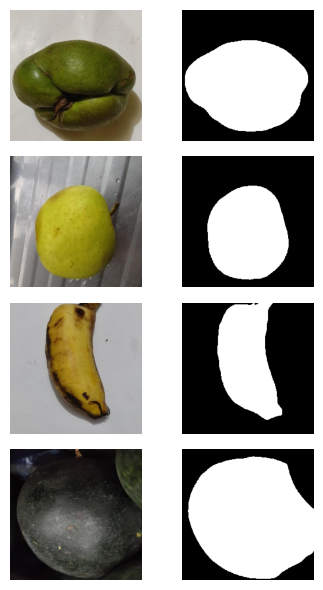

In [15]:
for x, y in get_batch(trainingPairs, 4):

    plt.figure(figsize=(4,6))

    for i in range(len(x)):

        plt.subplot(len(x), 2, 2*i + 1)
        plt.imshow(x[i])
        plt.axis("off")

        plt.subplot(len(x), 2, 2*i + 2)
        plt.imshow(y[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

    break

In [16]:
!pip install segmentation_models_pytorch -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 12.8 MB/s eta 0:00:00


In [17]:
import torch
import segmentation_models_pytorch as smp

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",     # (Transfer Learning)
    in_channels=3,
    classes=1
)

model.to(device)

# We use BCEWithLogitsLoss because the model outputs "Logits" (raw scores),
# not probabilities (0-1). This function applies Sigmoid internally + calculates loss.
loss_fn = torch.nn.BCEWithLogitsLoss() #Binary Cross Entropy

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [18]:
# Hyperparameters
EPOCHS = 50
BATCH_SIZE = 32
patience = 5
counter = 0
bestLoss = 100

# Training Loop
for epoch in range(EPOCHS):

    model.train()
    epoch_loss = 0
    epoch_acc = 0
    epoch_iou = 0
    total_batches = 0

    batch_generator = get_batch(trainingPairs, BATCH_SIZE)

    for x_np, y_np in batch_generator:

        x = torch.from_numpy(x_np).float().to(device)
        x = x.permute(0, 3, 1, 2)
        y = torch.from_numpy(y_np).float().to(device)
        y = y.permute(0, 3, 1, 2)

        optimizer.zero_grad()
        pred_logits = model(x)
        loss = loss_fn(pred_logits, y)
        loss.backward()
        optimizer.step()

        probs = torch.sigmoid(pred_logits)
        preds = (probs > 0.5).float()

        correct_pixels = (preds == y).sum().item()
        total_pixels = torch.numel(preds)
        acc = correct_pixels / total_pixels

        intersection = (preds * y).sum().item()
        union = preds.sum().item() + y.sum().item() - intersection

        iou = (intersection + 1e-6) / (union + 1e-6)

        epoch_loss += loss.item()
        epoch_acc += acc
        epoch_iou += iou
        total_batches += 1

    avg_loss = epoch_loss / total_batches
    avg_acc = epoch_acc / total_batches
    avg_iou = epoch_iou / total_batches

    print(f"Epoch {epoch+1} -> Loss: {avg_loss:.4f} | Accuracy: {avg_acc:.4f} | IoU: {avg_iou:.4f}")

    if avg_loss < bestLoss:
        torch.save(model.state_dict(), 'my_binary_unet.pth')
        bestLoss = avg_loss
        counter = 0
    else:
        counter += 1
        if counter == patience:
            print("Early Stopping!")
            break

Epoch 1 -> Loss: 0.3836 | Accuracy: 0.8393 | IoU: 0.7237
Epoch 2 -> Loss: 0.2011 | Accuracy: 0.9741 | IoU: 0.9273
Epoch 3 -> Loss: 0.1602 | Accuracy: 0.9840 | IoU: 0.9535
Epoch 4 -> Loss: 0.1334 | Accuracy: 0.9875 | IoU: 0.9636
Epoch 5 -> Loss: 0.1131 | Accuracy: 0.9899 | IoU: 0.9703
Epoch 6 -> Loss: 0.0978 | Accuracy: 0.9909 | IoU: 0.9735
Epoch 7 -> Loss: 0.0851 | Accuracy: 0.9921 | IoU: 0.9767
Epoch 8 -> Loss: 0.0741 | Accuracy: 0.9931 | IoU: 0.9798
Epoch 9 -> Loss: 0.0649 | Accuracy: 0.9941 | IoU: 0.9825
Epoch 10 -> Loss: 0.0579 | Accuracy: 0.9946 | IoU: 0.9841
Epoch 11 -> Loss: 0.0514 | Accuracy: 0.9950 | IoU: 0.9853
Epoch 12 -> Loss: 0.0463 | Accuracy: 0.9954 | IoU: 0.9866
Epoch 13 -> Loss: 0.0425 | Accuracy: 0.9954 | IoU: 0.9865
Epoch 14 -> Loss: 0.0380 | Accuracy: 0.9959 | IoU: 0.9880
Epoch 15 -> Loss: 0.0349 | Accuracy: 0.9961 | IoU: 0.9886
Epoch 16 -> Loss: 0.0328 | Accuracy: 0.9960 | IoU: 0.9882
Epoch 17 -> Loss: 0.0311 | Accuracy: 0.9958 | IoU: 0.9876
Epoch 18 -> Loss: 0.030

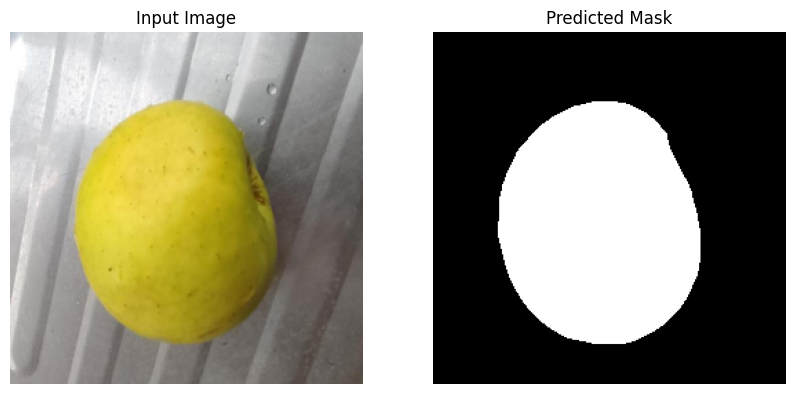

Inference Complete.


In [20]:
import torch
import segmentation_models_pytorch as smp
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
MODEL_PATH = '/content/my_binary_unet.pth'
IMAGE_PATH = '/content/55.jpg'
ENCODER = 'resnet34'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

def load_model():
    model = smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=None,
        in_channels=3,
        classes=1
    )
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))

    model.to(DEVICE)
    model.eval()

    return model

def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = cv2.resize(img, (256, 256))

    img_norm = img.astype('float32') / 255.0

    img_transposed = np.moveaxis(img_norm, -1, 0)

    img_tensor = torch.from_numpy(img_transposed).unsqueeze(0).float()

    return img, img_tensor.to(DEVICE)

def predict(img_path):
    _,img_tensor=preprocess_image(img_path)
    model = load_model()

    with torch.no_grad():
        logits = model(img_tensor)

        pr_masks = logits.sigmoid()
        pred_mask = (pr_masks > 0.5).float()

        result = pred_mask.squeeze().cpu().numpy()

    return result

if __name__ == "__main__":
    original_img, _ = preprocess_image(IMAGE_PATH)

    mask = predict(IMAGE_PATH)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Input Image")
    plt.imshow(original_img)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(mask, cmap='gray')
    plt.axis('off')

    plt.show()
    print("Inference Complete.")